In [1]:
############ LOAD PACKAGES
import numpy as np
import pandas as pd
import napari
import tifffile as tf
import matplotlib.pyplot as plt

# import custum colormaps
from colormaps import *

# import custum functions
from STP_plotting import *
from STP_processing import *

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2

In [2]:
# set-up vars
# home_dir = "/Volumes/Data/"
home_dir = "/mnt/labNAS/"

in_path = home_dir+"Emily/STP_for_MAPseq/4_python_output/input_tifs/"
out_path = home_dir+"Emily/STP_for_MAPseq/4_python_output/output_figs/"

metadata = pd.read_csv("stp_metadata.csv")

In [4]:
# import 230429 STeg brain- seems to be brighter than others???
steg_hs_asr = home_dir+"Emily/STP_for_MAPseq/2_fiji_adjusted/OMC_STeg_220429_b2_hand_straightened_asr.tif"
steg = tf.imread(steg_hs_asr)

# import example lab mouse aligned to sm
mmus_to_st_tif = in_path+"norm_subtracted/STeg_220429_aligned/OMC_MMus_220119_b0_aligned_to_STeg_220429_NO_subtracted.tif"
mmus = tf.imread(mmus_to_st_tif)

# import boundaries
# import aligned to hand-straight
boundaries_path = home_dir+"Emily/STP_for_MAPseq/3_brainreg_output/OMC_STeg_220429_b2_hand_straightened_asr_aligned_10um/boundaries_RESIZED.tif"
boundaries = tf.imread(boundaries_path)

In [6]:
# import masks
# areas made w/ script
areas = ["grey", "CTX", "OMCi", "OMCc", "ACAi", "ACAc", "aud","TH", "STR", "CP", "AMY", "P", "PG", "MB", "PAG", "SCm", 
         "SNr", "HY", "CNU", "TEa", "ECT", "VISC", "AI", "GU", "BS", "HIP"]

# import masks aligned to steg_hand_straightened_asr
masks_path = in_path+"masks/steg_220429_hs_asr/"

# load masks
masks = {}
for area in areas:
    with open(masks_path+"steg_220429_hs_asr_"+area+".npy", "rb") as f:
            mask = np.load(f)
    masks[area] = mask



<function dict.keys>

In [14]:
# apply PAG mask to steg image and mmus
pag = masks["PAG"]

steg_pag = np.multiply(steg, pag)
mmus_pag = np.multiply(mmus, pag)

In [29]:
pag_sum = pag.sum(axis=1).sum(axis=1)
print(np.nonzero(pag_sum)[0][0])
print(np.nonzero(pag_sum)[0][-1])
pag_sum[105:182]

105
181


array([   8,   80,  171,  279,  423,  544,  594,  621,  618,  673,  997,
       1344, 1597, 1747, 1819, 1902, 1883, 1805, 1714, 1627, 1637, 1721,
       1905, 2076, 2204, 2336, 2476, 2593, 2715, 2861, 3040, 3192, 3362,
       3524, 3678, 3811, 3932, 4031, 4115, 4141, 4091, 4101, 4156, 4224,
       4232, 4243, 4265, 4288, 4318, 4362, 4387, 4393, 4371, 4312, 4278,
       4264, 4255, 4209, 4162, 4114, 4126, 4210, 4273, 4302, 4301, 4294,
       4363, 4472, 4829, 4857, 4475, 3911, 3319, 2687, 1820,  565,  103])

In [36]:
# visualize in napari
viewer = napari.Viewer()
# add example image
viewer.add_image(
    steg_pag[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop orange",
    name="STeg_pag"
)

viewer.add_image(
    steg[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop orange",
    name="STeg"
)

# add example image
viewer.add_image(
    mmus_pag[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop blue",
    name="MMus_pag"
)

# add example image
viewer.add_image(
    mmus[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop blue",
    name="MMus"
)

# add example image
viewer.add_image(
    boundaries[105:182],
    scale=[50,20,20],
    blending="additive",
    name="boudaries"
)

<Image layer 'boudaries' at 0x7f565e50ff90>

In [93]:
# manually labelled PAG in STeg_220429
# import then save it as file
# import shapes
from napari.layers import Shapes

my_shapes = [layer for layer in viewer.layers if isinstance(layer, Shapes)]
# convert shapes layer to mask and collapse so same dims as images
pag_mask = my_shapes[0].to_masks([77,522,692]).sum(axis=0)
pag_nmask = my_shapes[1].to_masks([77,522,692]).sum(axis=0)
pag_fin = pag_mask - pag_nmask


In [94]:
# save pag_fin as mask

# initialize 0 numpy array
pag_out = np.zeros(pag.shape)
pag_out[105:182] = pag_fin


In [95]:
# save pag_out as npy -> taken from make_mask.py scirpt
# convert area_mask type to boolean to reduce size
area_mask = pag_out.astype("bool")

save_path = masks_path+"steg_220429_hs_asr_annotated_PAG.npy"
with open(save_path, "wb") as f:
    np.save(f, area_mask, allow_pickle=False)

In [96]:
with open(save_path, "rb") as f:
    in_pag = np.load(f)


In [97]:
# add example image
viewer.add_image(
    in_pag[105:182],
    scale=[50,20,20],
    blending="additive",
    name="pag_in"
)

<Image layer 'pag_in' at 0x7f58b8222890>

In [98]:
steg_pag = np.multiply(steg, in_pag)
mmus_pag = np.multiply(mmus, in_pag)

In [106]:
steg_pag[105:182].sum()

87932423

In [107]:
viewer.add_image(
    steg_pag[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop orange",
    name="STeg_pag"
)

viewer.add_image(
    mmus_pag[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop blue",
    name="MMus_pag"
)

<Image layer 'MMus_pag' at 0x7f562337f7d0>

In [111]:
# try filtering mask so that it's smoother
from scipy import ndimage

image = ndimage.median_filter(in_pag, size=10)


In [113]:
# save smoothed pag mask
area_mask = image.astype("bool")

save_path = masks_path+"steg_220429_hs_asr_annotated_smooth_PAG.npy"
with open(save_path, "wb") as f:
    np.save(f, area_mask, allow_pickle=False)

In [112]:
viewer.add_image(
    image[105:182],
    scale=[50,20,20],
    blending="additive",
    colormap="bop blue",
    name="pag_filt"
)

<Image layer 'pag_filt' at 0x7f56280fbb90>

In [124]:
# add scale bar
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"
# viewer.scale_bar.
# manipulate in napari until get orientation you want...
# take screenshot, specify size for highres
file_name = "st220429_mm220119_align220429_3d_pag1.png"
size = steg.shape[1:]
viewer.screenshot(out_path+file_name, canvas_only=True, size=(size))
print("done")

done


# 2D figures of PAG

In [114]:
# import custom smooth PAG mask
save_path = masks_path+"steg_220429_hs_asr_annotated_smooth_PAG.npy"
with open(save_path, "rb") as f:
    pag = np.load(f)

In [119]:
masks["custom_pag"] = pag

In [120]:
pag_mask_list = ["grey", "CTX", "TH", "HY", "PG", "MB", "custom_pag"]


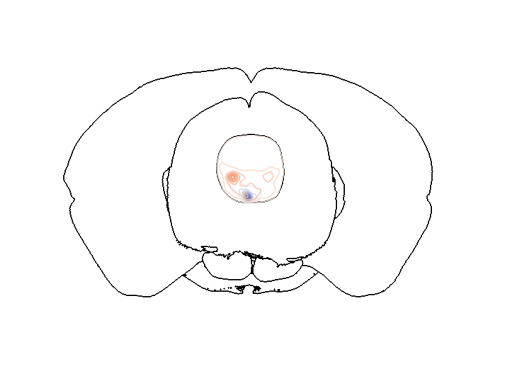

In [121]:
plot_contour_species(mmus, steg, mask_dict=masks, 
                     plot_areas=pag_mask_list, roi="custom_pag",
                     view="front")

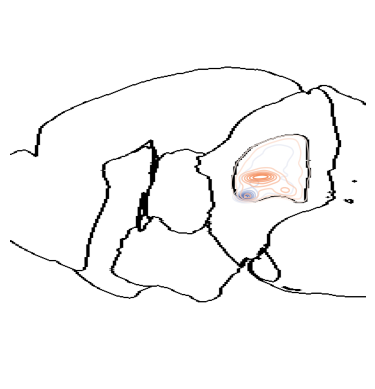

In [122]:
plot_contour_species(mmus, steg, mask_dict=masks, 
                     plot_areas=pag_mask_list, roi="custom_pag",
                     view="side")

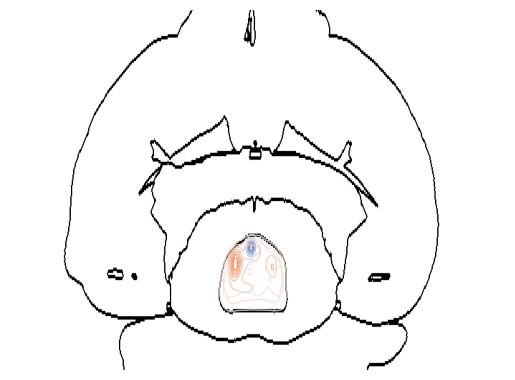

In [123]:
plot_contour_species(mmus, steg, mask_dict=masks, 
                     plot_areas=pag_mask_list, roi="custom_pag",
                     view="top")